In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
base = automap_base()

# reflect the tables
base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = base.classes.measurement
Station = base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Inspection of the measurement table to identify the columns and data types
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for col in columns:
    print(col["name"], col["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Inspection of the staion table to identify the columns and data types
inspector = inspect(engine)
columns = inspector.get_columns('station')
for col in columns:
    print(col["name"], col["type"])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(recent_date)

('2017-08-23',)


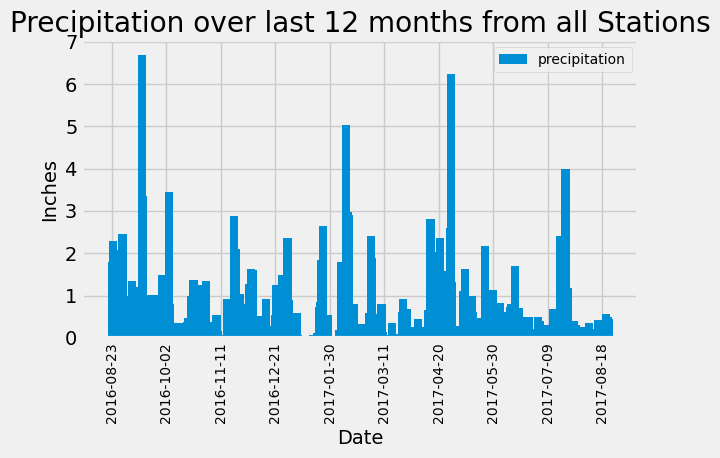

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
# Coverting Row Type to String and subsequently to Date
date_value = recent_date.date
date_obj = dt.date.fromisoformat(date_value)
# Subtracting 1 year (365 days) from the queried 'recent date'
year_from_date = date_obj - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
one_year_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_from_date).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(one_year_data, columns=['date', 'precipitation'])

# Sort the dataframe by date
df = df.sort_values(by='date')

# Cleaning - Removing of NaN values and Zero fron the dataframe
df_clean = df.dropna(subset=['precipitation'])
df_clean = df[df['precipitation'] > 0]
df_clean = df.reset_index(drop=True)

# Using Matplotlib to plot the data
x = df_clean['date']
y = df_clean['precipitation']
plt.bar(x,y, width=6, linewidth=0)

# x-axis scale alteration to reduce ticks
x_range = len(df.groupby(df['date']).count())
plt.xticks(range(0, x_range, 40), rotation=90, fontsize=10)

# y-axis scale adjustments
y_range = round(df_clean['precipitation'].max())+1
plt.yticks(range(0, y_range, 1))

# Chart formatting and saving to output folder
plt.title('Precipitation over last 12 months from all Stations')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Inches', fontsize=14)
plt.legend(['precipitation'], fontsize=10,)
plt.tight_layout()
plt.savefig("output/prcp_12month_all_stations.png")

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df.describe()
summary_stats

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
tot_no_stations = session.query(Station.station).distinct().count()
print(tot_no_stations)

9


In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [Measurement.station, func.count(Measurement.station)]
most_active_stations = session.query(*sel).group_by(Measurement.station).order_by(sel[1].desc())
for rec in most_active_stations:
    print(rec)


('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurement.station,
       func.count(Measurement.station),
       func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
most_active_station = session.query(sel[0], sel[2], sel[3], sel[4]).group_by(Measurement.station).order_by(sel[1].desc()).first()
print(most_active_station)

('USC00519281', 54.0, 85.0, 71.66378066378067)


In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Most active station
most_active_station_id = most_active_station[0]

# Oldest date for this station
oldest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# Coverting Row Type to String and subsequently to Date
date_value = oldest_date.date
date_obj = dt.date.fromisoformat(date_value)
# Subtracting 1 year (365 days) from the queried 'recent date'
one_year_from_date = date_obj - dt.timedelta(days=365)

# Query of 12 months temp data for specific station
one_year_temp_data = session.query(Measurement.tobs).\
                     filter(Measurement.station == most_active_station_id).\
                     filter(Measurement.date >= one_year_from_date)


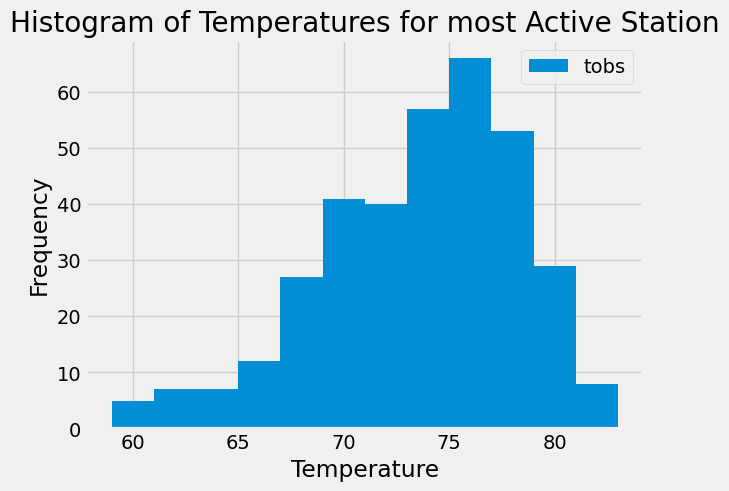

In [20]:
# Plotting of the histogram
df = pd.DataFrame(one_year_temp_data, columns=['tobs'])
df.plot.hist(bins=12)
plt.title('Histogram of Temperatures for most Active Station')
plt.xlabel('Temperature')
plt.savefig("output/hist_temp_most_active_station.png")


# Close Session

In [21]:
# Close Session
session.close()